In [3]:
import networkx as nx
import pandas as pd
import random
import torch
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import numpy as np

In [4]:
import torch
from torch_geometric.utils.convert import from_networkx
from pygod.detector import DOMINANT, OCGNN, GUIDE, GAE, GAAN, AnomalyDAE, CONAD
from pygod.metric import eval_f1, eval_precision_at_k, eval_recall_at_k
from pygod.generator import gen_contextual_outlier, gen_structural_outlier
import pickle
import time
device = torch.device('cuda')

In [5]:
import torchvision.models as models
import torch_geometric.nn as pyg_nn

In [7]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [1]:
unsw_labeled_path = "C:\\Users\\asus\\Documents\\nids-pcap-dataset\\unsw_parquet_used_dataset\\unsw_labeled.parquet"

In [6]:
unsw = pd.read_parquet(unsw_labeled_path)

In [7]:
unsw.is_malware.value_counts()

is_malware
0    110274
1     14906
Name: count, dtype: int64

In [8]:
#import plt
import matplotlib.pyplot as plt
def check_distribution(col_name):
    unsw_nd = unsw.drop_duplicates(subset=[col_name], keep='first')
    value_counts = unsw_nd.is_malware.value_counts()
    colors = ['red' if value == 1 else 'green' for value in value_counts.index]
    value_counts.plot(kind='bar', color=colors)
    plt.xlabel('is_malware')
    plt.ylabel('count')
    plt.title(col_name +' sebagai Node')
    for i, count in enumerate(value_counts):
        plt.text(i, count, str(count), ha='center', va='bottom', color='black')
    plt.show()

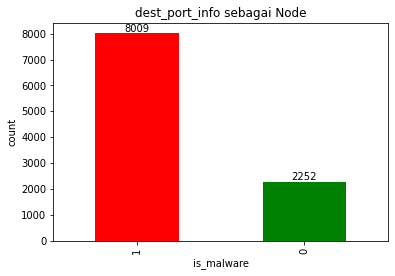

In [9]:
check_distribution('dest_port_info')

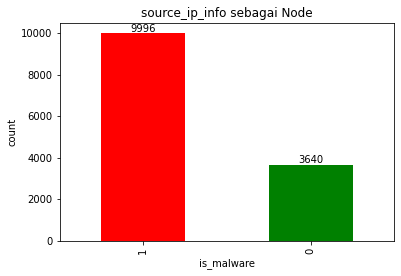

In [10]:
check_distribution('source_ip_info')

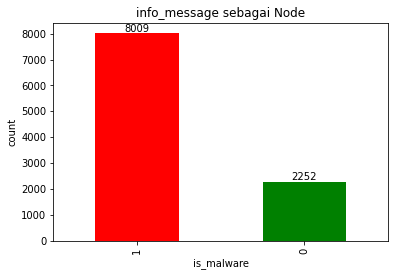

In [11]:
check_distribution('info_message')

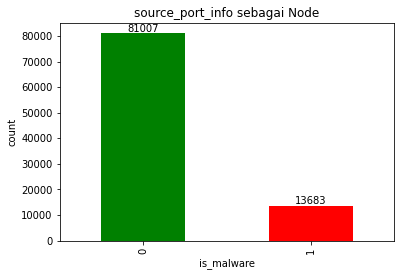

In [12]:
check_distribution('source_port_info')

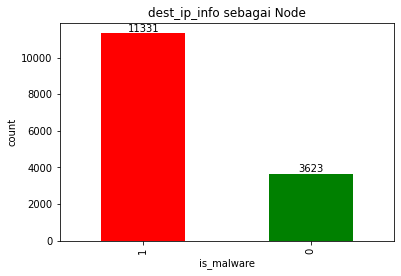

In [13]:
check_distribution('dest_ip_info')

In [18]:
def split_train_test(df, test_size=0.3, random_state = 0):
    train, test = train_test_split(df, test_size=test_size)
    return train, test

In [9]:
def graph_modeling_1(df):
    graph = nx.Graph()
    node_features = []
    labels = []

    for source_port_info in df["source_port_info"].unique():
        graph.add_node(source_port_info)
        info_message = df[df["source_port_info"] == source_port_info]["info_message"].iloc[0]
        label = df[df["source_port_info"] == source_port_info]["is_malware"].iloc[0]
        node_features.append([float(len(info_message))])
        labels.append(label)
        
    for (source_ip, source_port), group in df.groupby(["source_ip", "source_port"]):
        for i in range(len(group) - 1):
            from_node = group.iloc[i]["source_port_info"]
            to_node = group.iloc[i+1]["source_port_info"]
            if graph.has_edge(from_node, to_node):
                graph[from_node][to_node]["weight"] += 1
            else:
                graph.add_edge(from_node, to_node, weight=1)
    return graph, node_features, labels

In [19]:
train_df, test_df = split_train_test(unsw)

In [20]:
train_df.is_malware.value_counts()

is_malware
0    77213
1    10413
Name: count, dtype: int64

In [21]:
test_df.is_malware.value_counts()

is_malware
0    33061
1     4493
Name: count, dtype: int64

In [25]:
nD_train_df = train_df.drop_duplicates(subset=["source_port_info"], keep='first')
nD_train_df.is_malware.value_counts()

is_malware
0    61623
1     9676
Name: count, dtype: int64

In [26]:
nD_test_df = test_df.drop_duplicates(subset=["source_port_info"], keep='first')
nD_test_df.is_malware.value_counts()

is_malware
0    29850
1     4297
Name: count, dtype: int64

In [27]:
value_counts = train_df.is_malware.value_counts()
if value_counts[0] > 10398:
    benign = train_df[train_df['is_malware'] == 0].sample(n=10398)
    malicious = train_df[train_df['is_malware'] == 1].sample(n=5699)
    train_df = pd.concat([benign, malicious])
    # nD_train_df = train_df.copy()

In [28]:
value_counts = test_df.is_malware.value_counts()
if value_counts[0] > 5321:
    df_to_lower = test_df[test_df['is_malware'] == 0].sample(n=5321)
    test_df = pd.concat([test_df[test_df['is_malware'] == 1], df_to_lower])
    # nD_test_df = test_df.copy()

In [14]:
train_graph, train_node_features, label_train = graph_modeling_1(train_df)

In [15]:
test_graph, test_node_features, label_test = graph_modeling_1(test_df)

In [16]:
train_graph.number_of_nodes()

71378

In [17]:
test_graph.number_of_nodes()

34209

In [18]:
# print num of isolated nodes
print(len(list(nx.isolates(train_graph))))

30166


In [19]:
# print num of isolated nodes
print(len(list(nx.isolates(test_graph))))

24667


In [27]:
pickle.dump(train_graph, open('model_graph/train_graph_ip_port.pkl', 'wb'))
pickle.dump(train_node_features, open('model_graph/train_node_features_ip_port.pkl', 'wb'))
pickle.dump(label_train, open('model_graph/label_train_ip_port.pkl', 'wb'))

In [28]:
pickle.dump(test_graph, open('model_graph/test_graph_ip_port.pkl', 'wb'))
pickle.dump(test_node_features, open('model_graph/test_node_features_ip_port.pkl', 'wb'))
pickle.dump(label_test, open('model_graph/label_test_ip_port.pkl', 'wb'))

In [8]:
train_graph = pickle.load(open('model_graph/train_graph.pkl', 'rb'))
label_train = pickle.load(open('model_graph/label_train.pkl', 'rb'))
train_node_features = pickle.load(open('model_graph/train_node_features.pkl', 'rb'))

In [9]:
test_graph = pickle.load(open('model_graph/test_graph.pkl', 'rb'))
label_test = pickle.load(open('model_graph/label_test.pkl', 'rb'))
test_node_features = pickle.load(open('model_graph/test_node_features.pkl', 'rb'))

In [10]:
print(train_graph.number_of_nodes())
print(test_graph.number_of_nodes())

15451
9525


In [11]:
#print number of isolated node in train_graph
print(len(list(nx.isolates(train_graph))))
print(len(list(nx.isolates(test_graph))))

0
0


## DOMINANT

In [12]:
def make_dominant_model(train_graph, train_node_features, 
                        label_train, test_graph, test_node_features):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)
    test_node_features = torch.tensor(test_node_features)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train
    pyG_train.x = train_node_features

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features
    print(len(pyG_train))

    dominant_model = DOMINANT(gpu=-1, weight=1, weight_decay=3, num_layers=16, hid_dim=16, contamination=0.37, lr=0.001, verbose=3, epoch=100)  
    dominant_compile = dominant_model.fit(pyG_train)
    return dominant_compile, pyG_test

In [29]:
def predict_dominant(label_test, dominant_compile, pyG_test):
    
    label_test = torch.tensor(label_test)
    dominant_ip_pred_res, dominant_ip_score_res = dominant_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear')
    
    unique_values, counts = torch.unique(dominant_ip_pred_res, return_counts=True)
    print(unique_values, counts)

    f1_pygod = eval_f1(label_test, dominant_ip_pred_res)
    precision_pygod = eval_precision_at_k(label_test, dominant_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, dominant_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return precision_pygod, recall_pygod, f1_pygod

In [30]:
dominant_model, graph_test = make_dominant_model(train_graph, train_node_features, label_train, test_graph, test_node_features)
precision_score, recall_score, f1_score = predict_dominant(label_test, dominant_model, graph_test)

C:\Users\asus\AppData\Local\Temp\ipykernel_9108\1513033408.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)
C:\Users\asus\AppData\Local\Temp\ipykernel_9108\1513033408.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train)
C:\Users\asus\AppData\Local\Temp\ipykernel_9108\1513033408.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)


4
torch.Size([15451, 1]) torch.Size([15451, 15451]) torch.Size([2, 32161])
torch.Size([15451, 1]) torch.Size([15451, 15451])
Epoch 0000: Loss 75.0444 |  | Time 4.18
torch.Size([15451, 1]) torch.Size([15451, 15451]) torch.Size([2, 32161])
torch.Size([15451, 1]) torch.Size([15451, 15451])
Epoch 0001: Loss 75.0020 |  | Time 3.69
torch.Size([15451, 1]) torch.Size([15451, 15451]) torch.Size([2, 32161])
torch.Size([15451, 1]) torch.Size([15451, 15451])


KeyboardInterrupt: 

In [106]:
# print("ini f1: ", f1)
print("ini precision: ", precision_score)
print("ini recall: ", recall_score)
print("ini f1_score_unv: ", f1_score_for)

ini precision:  tensor(0.7065)
ini recall:  tensor(0.7065)
ini f1_score_unv:  0.7008086253369271


## OCGNN

In [27]:
def predict_ocgnn(label_test, ocgnn_compile, pyG_test, test_node_features):
    
    label_test = torch.tensor(label_test)
    test_node_features = torch.tensor(test_node_features)

    pyG_test = from_networkx(pyG_test)
    pyG_test = pyG_test
    pyG_test.x = test_node_features

    ocgnn_ip_pred_res, ocgnn_ip_score_res = ocgnn_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')
    
    unique_values, counts = torch.unique(ocgnn_ip_pred_res, return_counts=True)
    print(unique_values, counts)

    precision_pygod = eval_precision_at_k(label_test, ocgnn_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, ocgnn_ip_score_res)
    f1_score = 2 * (precision_pygod * recall_pygod) / (precision_pygod + recall_pygod)
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)

    return precision_pygod, recall_pygod, f1_score

In [28]:
def make_ocgnn_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train.cpu()
    pyG_train.x = train_node_features.cpu()
    label_train = label_train.cpu()

    ocgnn_model = OCGNN(hid_dim=14, num_layers=32, weight_decay=1, 
                    contamination=0.37, lr=0.004, epoch=100, gpu=-1, 
                    verbose=3)
    ocgnn_compile = ocgnn_model.fit(pyG_train, label_train)
    return ocgnn_compile


In [33]:
# ocgnn_model = make_ocgnn_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score= predict_ocgnn(label_test, ocgnn_model, test_graph, test_node_features)
print("ini f1: ", f1_score)
print("ini precision: ", precision_score)
print("ini recall: ", recall_score)

Test: Loss 0.0000 | AUC 0.4945 | Recall 0.9573 | Precision 0.9573 | AP 0.4501 | F1 0.0479 | Time 0.06
tensor([1]) tensor([9484])
F1 score:  tensor(0.9573)
Precision:  tensor(0.9573)
Recall:  tensor(0.9573)
ini f1:  tensor(0.9573)
ini precision:  tensor(0.9573)
ini recall:  tensor(0.9573)


In [170]:
print(f1_ocgnn)
print(precision_ocgnn)
print(recall_ocgnn)

NameError: name 'f1_ocgnn' is not defined

In [ ]:
print(train_durration_ocgnn)
print(predict_durration_ocgnn)

[37.998138189315796, 34.89245128631592, 37.14145493507385]
[1.1997323036193848, 1.2506287097930908, 0.970118522644043]


## GAE

In [7]:
def make_gae_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train.cpu()
    pyG_train.x = train_node_features.cpu()
    label_train = label_train.cpu()

    gae_model = GAE(hid_dim=12, num_layers=12, weight_decay=3,
                contamination=0.37, lr=0.001, epoch=100, gpu=-1,
                verbose=3, recon_s=True, sigmoid_s=True)
    
    gae_compile = gae_model.fit(pyG_train, label_train)
    return gae_compile

In [37]:
def predict_gae(gae_compile, test_graph, test_node_features, label_test):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features

    gae_ip_pred_res, gae_ip_score_res = gae_compile.predict(data=pyG_test, label = label_test,return_pred=True, return_score=True, prob_method='linear')
    f1_score_pygod = eval_f1(label_test, gae_ip_pred_res)
    precision = eval_precision_at_k(label_test, gae_ip_score_res)
    recall = eval_recall_at_k(label_test, gae_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score pygod: ", f1_score_pygod)
    
    return f1_score_pygod, precision, recall, f1_score

In [38]:
gae_model = make_gae_model(train_graph, train_node_features, label_train)
f1_score_pygod, precision_score, recall_score, f1_score = predict_gae(gae_model, test_graph, test_node_features, label_test)

Epoch 0000: Loss 0.2514 | AUC 0.7764 | Recall 0.6538 | Precision 0.6538 | AP 0.6237 | F1 0.6998 | Time 4.66
Epoch 0001: Loss 0.2510 | AUC 0.7768 | Recall 0.6533 | Precision 0.6533 | AP 0.6235 | F1 0.6997 | Time 4.18
Epoch 0002: Loss 0.2507 | AUC 0.7771 | Recall 0.6535 | Precision 0.6535 | AP 0.6235 | F1 0.6995 | Time 3.92
Epoch 0003: Loss 0.2505 | AUC 0.7772 | Recall 0.6535 | Precision 0.6535 | AP 0.6236 | F1 0.6996 | Time 3.79
Epoch 0004: Loss 0.2504 | AUC 0.7771 | Recall 0.6531 | Precision 0.6531 | AP 0.6235 | F1 0.6995 | Time 3.72
Epoch 0005: Loss 0.2504 | AUC 0.7771 | Recall 0.6531 | Precision 0.6531 | AP 0.6235 | F1 0.6994 | Time 3.71
Epoch 0006: Loss 0.2504 | AUC 0.7772 | Recall 0.6533 | Precision 0.6533 | AP 0.6236 | F1 0.6995 | Time 3.73
Epoch 0007: Loss 0.2504 | AUC 0.7771 | Recall 0.6529 | Precision 0.6529 | AP 0.6235 | F1 0.6992 | Time 3.73
Epoch 0008: Loss 0.2504 | AUC 0.7720 | Recall 0.6533 | Precision 0.6533 | AP 0.6221 | F1 0.6994 | Time 3.61
Epoch 0009: Loss 0.2505 | AU

IndexError: index 9479 is out of bounds for dimension 0 with size 9479

## CONAD

In [16]:
def make_conad_model(train_graph, train_node_features, 
                        label_train):
    
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    print(train_node_features)
    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train.cpu()
    pyG_train.x = train_node_features.cpu()
    label_train = label_train.cpu()

    conad_model = CONAD(hid_dim=5, num_layers=5, 
                        lr=0.001, weight_decay= 1, contamination=0.37,
                        epoch=5, gpu=-1,  
                        weight=1, dropout=0.2, verbose=3)
    conad_compile = conad_model.fit(pyG_train, label_train)

    return conad_compile

In [17]:
def predict_conad(conda_compile, test_graph, test_node_features, label_test):
    
    test_node_features = torch.tensor(test_node_features)
    label_test = torch.tensor(label_test)

    pyG_test = from_networkx(test_graph)
    pyG_test = pyG_test
    pyG_test.x = test_node_features
    
    conad_ip_pred_res, conad_ip_score_res = conda_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear', )
    f1_score_pygod = eval_f1(label_test, conad_ip_pred_res)
    precision = eval_precision_at_k(label_test, conad_ip_score_res)
    recall = eval_recall_at_k(label_test, conad_ip_score_res)
    f1_score = 2*(precision*recall)/(precision+recall)
    
    unique_values, counts = torch.unique(conad_ip_pred_res, return_counts=True)
    print(unique_values, counts)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score pygod: ", f1_score_pygod)
    return f1_score_pygod, precision, recall

In [18]:
conad_model = make_conad_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_conad(conad_model, test_graph, label_test,  test_node_features)

C:\Users\asus\AppData\Local\Temp\ipykernel_25848\3220961629.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_node_features = torch.tensor(train_node_features)
C:\Users\asus\AppData\Local\Temp\ipykernel_25848\3220961629.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_train = torch.tensor(label_train)


tensor([[ 15.],
        [ 28.],
        [ 15.],
        ...,
        [248.],
        [ 24.],
        [ 37.]])
Epoch 0000: Loss 46.3383 | AUC 0.8649 | Recall 0.7577 | Precision 0.7577 | AP 0.7437 | F1 0.7577 | Time 7.64
Epoch 0001: Loss 46.3969 | AUC 0.8632 | Recall 0.7530 | Precision 0.7530 | AP 0.7420 | F1 0.7530 | Time 4.79
Epoch 0002: Loss 46.1873 | AUC 0.8648 | Recall 0.7579 | Precision 0.7579 | AP 0.7434 | F1 0.7579 | Time 4.23
Epoch 0003: Loss 46.0007 | AUC 0.8627 | Recall 0.7543 | Precision 0.7543 | AP 0.7430 | F1 0.7543 | Time 3.90
Epoch 0004: Loss 45.9383 | AUC 0.8664 | Recall 0.7629 | Precision 0.7629 | AP 0.7448 | F1 0.7629 | Time 3.98


C:\Users\asus\AppData\Local\Temp\ipykernel_25848\2188174777.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_node_features = torch.tensor(test_node_features)
C:\Users\asus\AppData\Local\Temp\ipykernel_25848\2188174777.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_test = torch.tensor(label_test)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got -2)

## AnomalyDAE

In [12]:
def make_anomalydae_model(train_graph, train_node_features, 
                        label_train):
    train_node_features = torch.tensor(train_node_features)
    label_train = torch.tensor(label_train)

    pyG_train = from_networkx(train_graph)
    pyG_train = pyG_train
    pyG_train.x = train_node_features
    label_train = label_train

    anomalydae_model = AnomalyDAE(hid_dim=12, emb_dim=4, 
                        lr=0.001, contamination=0.37,
                        epoch=10, gpu=-1,
                        weight=1, verbose=3)
    anomalydae_compile = anomalydae_model.fit(pyG_train, label_train)

    return anomalydae_compile

In [13]:
def predict_anomalydae(label_test, anomalydae_compile, pyG_test, test_node_features):

    test_node_features = torch.tensor(test_node_features)
    label_test = torch.tensor(label_test)
    
    pyG_test = from_networkx(pyG_test)
    pyG_test.x = test_node_features

    anomalydae_ip_pred_res, anomalydae_ip_score_res = anomalydae_compile.predict(data=pyG_test, label = label_test, return_pred=True, return_score=True, prob_method='linear', )
    
    precision_pygod = eval_precision_at_k(label_test, anomalydae_ip_score_res)
    recall_pygod = eval_recall_at_k(label_test, anomalydae_ip_score_res)
    f1_score = 2*(precision_pygod*recall_pygod)/(precision_pygod+recall_pygod)
    
    print("F1 score: ", f1_score)
    print("Precision: ", precision_pygod)
    print("Recall: ", recall_pygod)
    return f1_score, precision_pygod, recall_pygod

In [14]:

anomalydae_model = make_anomalydae_model(train_graph, train_node_features, label_train)
precision_score, recall_score, f1_score = predict_anomalydae(label_train, anomalydae_model, train_graph, train_node_features)

Epoch 0000: Loss 678.8920 | AUC 0.7747 | Recall 0.6758 | Precision 0.6758 | AP 0.6249 | F1 0.7122 | Time 10.01
Epoch 0001: Loss 84.9636 | AUC 0.7631 | Recall 0.6598 | Precision 0.6598 | AP 0.6209 | F1 0.6672 | Time 8.56
Epoch 0002: Loss 84.8900 | AUC 0.7632 | Recall 0.6598 | Precision 0.6598 | AP 0.6207 | F1 0.6673 | Time 8.93
Epoch 0003: Loss 84.8161 | AUC 0.7639 | Recall 0.6622 | Precision 0.6622 | AP 0.6211 | F1 0.6688 | Time 8.62
Epoch 0004: Loss 84.7414 | AUC 0.7639 | Recall 0.6622 | Precision 0.6622 | AP 0.6210 | F1 0.6687 | Time 8.71
Epoch 0005: Loss 84.6659 | AUC 0.7638 | Recall 0.6622 | Precision 0.6622 | AP 0.6208 | F1 0.6687 | Time 8.71
Epoch 0006: Loss 84.5894 | AUC 0.7637 | Recall 0.6626 | Precision 0.6626 | AP 0.6206 | F1 0.6688 | Time 9.37
Epoch 0007: Loss 84.5121 | AUC 0.7635 | Recall 0.6626 | Precision 0.6626 | AP 0.6203 | F1 0.6688 | Time 9.14
Epoch 0008: Loss 84.4339 | AUC 0.7634 | Recall 0.6622 | Precision 0.6622 | AP 0.6199 | F1 0.6687 | Time 9.56
Epoch 0009: Loss 